## Intro

Here, we will see the extrapolation potential - and problems - of neural networks. We have trained two simple networsk with one, 128-neuron hidden layer, to imitate the identity transformation on $x ~ N(0, 1)$. We'll see how well they perform outside that domain. (The only difference between them is the nonlinearity - one ELU, one ReLU).

In [1]:
from utils import *
from simple import *

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

fname = 'extrapolation128'

hidden=128
datasize, learning_rate, epochs = get_params(fname)
print([datasize, learning_rate, epochs])

Le, Lre = get_losses(fname)

e, re = get_models(fname)

datasize,learning_rate,epochs

[2048, 0.001, 50000]


## Learning

First, let's take a look at the learning curves, to make sure that the net seems to have plateaued. To avoid wasting space, the first several losses won't be visible.

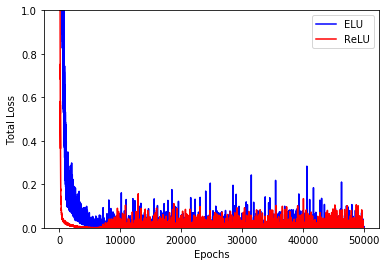

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
plt.plot(range(1, len(Le)+1), Le, 'b-', label="ELU")
plt.plot(range(1, len(Le)+1), Lre, 'r-', label="ReLU")
plt.ylim([0, 1])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.legend()

fig

It appears that both losses have plateaued. Where?

In [3]:
print("ELU")
print(Le[-10:])
print("ReLU")
print(Lre[-10:])

ELU
[0.0008007943979464471, 0.0012366985902190208, 0.0011932370252907276, 0.0006470405496656895, 0.0001588979212101549, 0.00028175924671813846, 0.0008450021268799901, 0.0018042146693915129, 0.003338984213769436, 0.0045767901465296745]
ReLU
[1.375416832161136e-05, 6.672461495327298e-06, 5.677729859598912e-06, 7.989461664692499e-06, 1.421523393219104e-05, 2.0317043890827335e-05, 2.449269959470257e-05, 3.100381582044065e-05, 3.7963709473842755e-05, 4.264150629751384e-05]


Great. Now, let's examin the behavior far from the training distribution

## Plots of The Function

In [4]:
# Get data and ground truth

x = np.arange(-10, 10, 0.01)
y = np.arange(-10, 10, 0.01)

In [5]:
# Compute network output

data = torch.FloatTensor(x.reshape(-1, 1)).cuda()

oe = e(data)
ore = re(data)

ye = oe.cpu().detach().numpy()
yre = ore.cpu().detach().numpy()

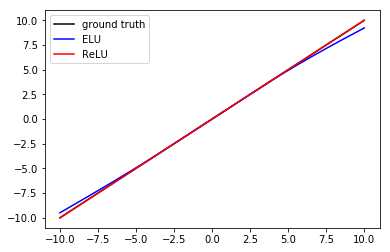

In [6]:
# Plot output

fig = plt.figure()

plt.plot(x, y, 'k-', label="ground truth")
plt.plot(x, ye, 'b-', label="ELU")
plt.plot(x, yre, 'r-', label="ReLU")

plt.legend()

fig

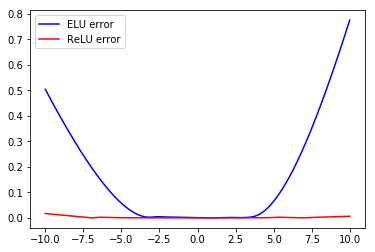

In [7]:
# Plot the L2 error

fig = plt.figure()

plt.plot(x, np.sqrt((ye.reshape(2000)-y)**2), 'b-', label="ELU error")
plt.plot(x, np.sqrt((yre.reshape(2000)-y)**2), 'r-', label="ReLU error")

plt.legend()

fig

Ther seems to be a significant error even here, for both networks, even though ReLU is far closer (about 2 percent).

Let's look at the internals of these networks in order to see where we can expect further errors.

In [8]:
print("ReLU")

print(re.fc1.weight)
print(re.fc1.bias)
print(-re.fc1.bias.view(-1, 1)/re.fc1.weight)

print("\n\n#######################\n\n")

print(re.fc2.weight)
print(re.fc2.bias)

ReLU
Parameter containing:
tensor([[ 1.9140e-01],
        [ 1.0239e-01],
        [ 3.3002e-01],
        [-2.0939e-02],
        [-6.0774e-01],
        [-5.8757e-01],
        [ 8.8235e-01],
        [-2.8605e-01],
        [ 3.9791e-01],
        [-4.6540e-02],
        [ 9.1776e-01],
        [-3.4349e-01],
        [-4.7789e-01],
        [ 3.1316e-01],
        [ 7.0981e-01],
        [ 5.0287e-01],
        [-8.7413e-01],
        [ 3.0044e-01],
        [ 2.4251e-01],
        [ 4.7871e-01],
        [-2.6753e-07],
        [ 9.6611e-01],
        [-9.2517e-01],
        [-7.0891e-01],
        [-8.7213e-01],
        [-2.4404e-01],
        [ 2.3226e-02],
        [-8.8918e-01],
        [-6.2089e-01],
        [ 1.3672e-01],
        [ 2.1563e-02],
        [-6.6269e-01],
        [-8.2133e-01],
        [-1.1223e-01],
        [-2.8321e-01],
        [ 9.9244e-01],
        [-4.0112e-01],
        [-4.1963e-01],
        [ 4.5583e-02],
        [ 3.5891e-01],
        [ 7.2298e-01],
        [ 5.8926e-01],
       

Based on $ - b / w$, we see that between $-100$ and $+100$, we should scroll past all the "elbows" of the ReLU functions. What about the ELU?

In [9]:
print("ELU")

print(e.fc1.weight)
print(e.fc1.bias)
print(-e.fc1.bias.view(-1, 1)/e.fc1.weight)

print("\n\n#######################\n\n")

print(e.fc2.weight)
print(e.fc2.bias)

ELU
Parameter containing:
tensor([[-4.8979e-02],
        [-9.4346e-01],
        [ 9.3810e-02],
        [-3.8845e-01],
        [ 5.9043e-01],
        [ 6.2830e-01],
        [ 6.2281e-01],
        [-7.5057e-02],
        [ 9.6944e-02],
        [-2.6055e-01],
        [ 6.4183e-01],
        [ 6.6722e-01],
        [-1.4981e-01],
        [ 3.6376e-01],
        [-2.6540e-09],
        [-4.7495e-01],
        [-5.9900e-01],
        [ 7.5255e-01],
        [-2.9206e-01],
        [-9.2207e-01],
        [-2.8982e-01],
        [-1.0926e-01],
        [ 2.0078e-01],
        [ 1.6357e-01],
        [-8.9894e-01],
        [-9.5944e-01],
        [-7.0018e-01],
        [-4.1885e-01],
        [-9.2109e-01],
        [-8.8568e-09],
        [ 3.0749e-01],
        [-5.8178e-01],
        [ 1.7676e-01],
        [-6.8392e-01],
        [-4.1859e-01],
        [ 6.9921e-01],
        [ 9.8982e-03],
        [-8.0513e-01],
        [ 6.6560e-01],
        [-1.5688e-01],
        [-2.7018e-01],
        [ 6.8708e-01],
        

ELU too. Let's go to $1000$, to appreciate the behavior at the asymptotes.

In [10]:
# Get data and ground truth

x = np.arange(-1000, 1000, 1.)
y = np.arange(-1000, 1000, 1.)

In [11]:
# Compute network output

data = torch.FloatTensor(x.reshape(-1, 1)).cuda()

oe = e(data)
ore = re(data)

ye = oe.cpu().detach().numpy()
yre = ore.cpu().detach().numpy()

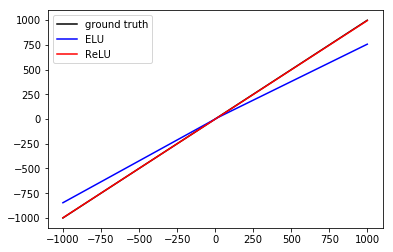

In [12]:
# Plot output

fig = plt.figure()

plt.plot(x, y, 'k-', label="ground truth")
plt.plot(x, ye, 'b-', label="ELU")
plt.plot(x, yre, 'r-', label="ReLU")

plt.legend()

fig

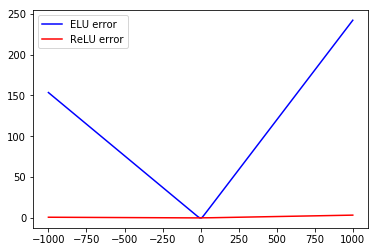

In [13]:
# Plot the L2 error

fig = plt.figure()

plt.plot(x, np.sqrt((ye.reshape(2000)-y)**2), 'b-', label="ELU error")
plt.plot(x, np.sqrt((yre.reshape(2000)-y)**2), 'r-', label="ReLU error")

plt.legend()

fig

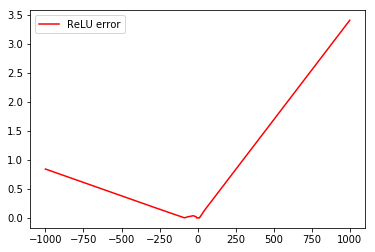

In [14]:
# Focus only on ReLU

fig = plt.figure()

plt.plot(x, np.sqrt((yre.reshape(2000)-y)**2), 'r-', label="ReLU error")

plt.legend()

fig

/nfs01/shared_software/anaconda3/envs/artem/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


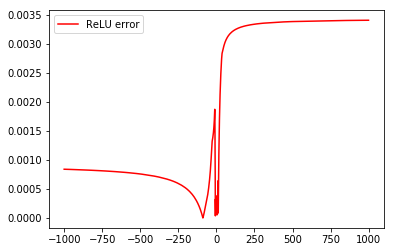

In [15]:
# Focus only on ReLU

fig = plt.figure()

plt.plot(x, np.sqrt((yre.reshape(2000)-y)**2)/abs(y), 'r-', label="ReLU error")

plt.legend()

fig

/nfs01/shared_software/anaconda3/envs/artem/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


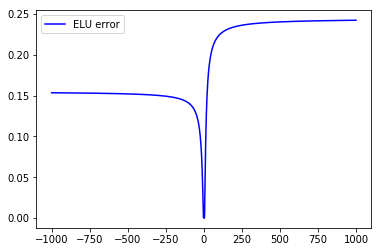

In [17]:
# Focus only on ELU

fig = plt.figure()

plt.plot(x, np.sqrt((ye.reshape(2000)-y)**2)/abs(y), 'b-', label="ELU error")

plt.legend()

fig

## Concluding Thoughts

ReLU has an admittedly low error, but only because the Id function sits within its domain. ELU has an error that is greater than 20 percent as x goes to infinity.